In [3]:
#imports
import torch
import numpy as np
import pandas as pd
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
import time
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import copy
import os
import pickle

In [4]:
#read files
def unpickle(file):
    
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [5]:
#data processing
def reshape_images(data_dict):
    reshaped = data_dict.numpy().reshape(len(data_dict), 1024, 3, order = 'F').reshape(len(data_dict), 32,32,3)
    reshaped_processed = torch.from_numpy(reshaped).float().permute(0, 3, 1, 2)
    return reshaped_processed

## Settings

In [6]:
#data settings
subset = True #for local running
k = 3 #number of samples needed to each class in validation set, because we need to split train and validation

#model settings
USE_TENSORBOARD = False
if USE_TENSORBOARD:
    foo = SummaryWriter()
use_gpu = False

#lr scheduler
BASE_LR = 0.001
EPOCH_DECAY = 4
DECAY_WEIGHT = 0.5

## Load Data and Process

In [7]:
test_dict = unpickle('./cifar-100-python/test')
train_dict = unpickle('./cifar-100-python/train')
meta = unpickle('./cifar-100-python/meta')

In [8]:
label_names = meta[b'fine_label_names']

In [9]:
if subset:
    train_data = torch.from_numpy(train_dict[b'data'][:1000])
    train_y = torch.tensor(train_dict[b'fine_labels'][:1000])
    test_data = torch.from_numpy(test_dict[b'data'][:100])
    test_y = torch.tensor(test_dict[b'fine_labels'][:100])
else:
    train_data = torch.from_numpy(train_dict[b'data'])
    train_y = torch.tensor(train_dict[b'fine_labels'])
    test_data = torch.from_numpy(test_dict[b'data'])
    test_y = torch.tensor(test_dict[b'fine_labels'])

In [10]:
def see_plot(phase, sample_id, test_y = test_y, label_names = label_names, test_data = test_data, train_y = train_y, train_data = train_data):
    
    if phase == 'train':
        data = train_data
        y = train_y
    elif phase == 'test':
        data = test_data
        y = test_y
    assert sample_id < len(data)
    plt.imshow(data[sample_id].numpy().reshape(-1,3, order = 'F').reshape(32,32,3))
    labeli = y[sample_id].item()
    plt.title('label: ' + label_names[labeli].decode("utf-8") + ', label id: ' + str(labeli))

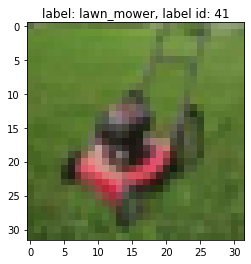

In [11]:
# see pictures by sample id
see_plot('train', 500)

In [12]:
def sampleFromClass(ds, k): 
    #k: number of samples needed to each class in test set
    class_counts = {}
    train_data = []
    train_label = []
    test_data = []
    test_label = []
    for data, label in ds:
        c = label.item()
        class_counts[c] = class_counts.get(c, 0) + 1
        if class_counts[c] > k:
            train_data.append(data)
            train_label.append(torch.unsqueeze(label, 0))
        else:
            test_data.append(data)
            test_label.append(torch.unsqueeze(label, 0))
    train_data = torch.stack(train_data)
    train_label = torch.cat(train_label)
    test_data = torch.stack(test_data)
    test_label = torch.cat(test_label)

    return ((train_data, train_label), 
        (test_data, test_label))

In [13]:
train_dataset, validation_dataset = sampleFromClass(list(zip(train_data, train_y)), k)
test_dataset = test_data, test_y

In [14]:
train_images = TensorDataset(reshape_images(train_dataset[0]), train_dataset[1])
val_images = TensorDataset(reshape_images(validation_dataset[0]), validation_dataset[1])
test_images = TensorDataset(reshape_images(test_dataset[0]), test_dataset[1])

In [15]:
trainloader = torch.utils.data.DataLoader(train_images, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(val_images, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_images, batch_size=len(test_images), shuffle=False)

In [16]:
dset_loaders = {'train': trainloader, 'val': valloader, 'test': testloader}
dset_sizes = {'train': len(trainloader.dataset), 'val': len(valloader.dataset), 'test': len(testloader.dataset)}

## Load Model and Utilities

In [20]:
#train model
def train_model(model, criterion, optimizer, lr_scheduler, num_epochs=5):
    since = time.time()

    best_model = model
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                mode='train'
                optimizer = lr_scheduler(optimizer, epoch)
                model.train()  # Set model to training mode
            else:
                model.eval()
                mode='val'

            running_loss = 0.0
            running_corrects = 0

            counter=0
            # Iterate over data.
            for data in dset_loaders[phase]:
                inputs, labels = data
                #print(inputs.size())
                # wrap them in Variable
                if use_gpu:
                    try:
                        inputs, labels = Variable(inputs.float().cuda()),                             
                        Variable(labels.long().cuda())
                    except:
                        print(inputs,labels)
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # Set gradient to zero to delete history of computations in previous epoch. Track operations so that differentiation can be done automatically.
                optimizer.zero_grad()
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                
                loss = criterion(outputs, labels)
                # print('loss done')                
                # Just so that you can keep track that something's happening and don't feel like the program isn't running.
                # if counter%10==0:
                #     print("Reached iteration ",counter)
                counter+=1

                # backward + optimize only if in training phase
                if phase == 'train':
                    # print('loss backward')
                    loss.backward()
                    # print('done loss backward')
                    optimizer.step()
                    # print('done optim')
                # print evaluation statistics
                try:
                    # running_loss += loss.data[0]
                    running_loss += loss.item()
                    # print(labels.data)
                    # print(preds)
                    running_corrects += torch.sum(preds == labels.data)
                    # print('running correct =',running_corrects)
                except:
                    print('unexpected error, could not calculate loss or do a sum.')
            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects.item() / float(dset_sizes[phase])
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))


            # deep copy the model
            if phase == 'val':
                if USE_TENSORBOARD:
                    foo.add_scalar('epoch_loss',epoch_loss,epoch)
                    foo.add_scalar('epoch_acc',epoch_acc,epoch)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model = copy.deepcopy(model)
                    print('new best accuracy = ',best_acc)
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('returning and looping back')
    if USE_TENSORBOARD:
        foo.close()
    return best_model

# This function changes the learning rate over the training model.
def exp_lr_scheduler(optimizer, epoch, init_lr=BASE_LR, lr_decay_epoch=EPOCH_DECAY):
    """Decay learning rate by a factor of DECAY_WEIGHT every lr_decay_epoch epochs."""
    lr = init_lr * (DECAY_WEIGHT**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

#test model
def test_model(model):
    model.eval()
    running_loss = 0
    running_corrects = 0
    for data in dset_loaders['test']:
        inputs, labels = data
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        corrects = torch.sum(preds == labels.data) 
        loss = criterion(outputs, labels)
        running_loss += loss
        running_corrects += corrects
    accuracy = (running_corrects / float(dset_sizes['test'])).item()
    loss = (running_loss / dset_sizes['test']).item()
    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                'test', loss, accuracy))
    return loss, accuracy

In [21]:
#setting model, criterion and optimers
vgg16 = models.vgg16(pretrained = True)
#change target output features count into 100
vgg16.classifier[-1] = nn.Linear(in_features=4096, out_features=100, bias = True)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg16.parameters(), lr=0.001)

In [22]:
train_model(vgg16, criterion, optimizer, exp_lr_scheduler, num_epochs=2);

Epoch 0/1
----------
LR is set to 0.001
trying epoch loss
train Loss: 0.1695 Acc: 0.0143
trying epoch loss
val Loss: 0.0869 Acc: 0.0100
new best accuracy =  0.01
Epoch 1/1
----------
trying epoch loss
train Loss: 0.0750 Acc: 0.0100
trying epoch loss
val Loss: 0.0783 Acc: 0.0100
Training complete in 1m 26s
Best val Acc: 0.010000
returning and looping back


In [23]:
loss, accuracy = test_model(vgg16)

test Loss: 0.0469 Acc: 0.0100


In [415]:
#visualize tensorboard -- a little buggy...
if USE_TENSORBOARD:
    %load_ext tensorboard
    %tensorboard --logdir=runs

[libprotobuf ERROR external/protobuf_archive/src/google/protobuf/descriptor_database.cc:334] Invalid file descriptor data passed to EncodedDescriptorDatabase::Add().
[libprotobuf FATAL external/protobuf_archive/src/google/protobuf/descriptor.cc:1370] CHECK failed: GeneratedDatabase()->Add(encoded_file_descriptor, size): 
libc++abi.dylib: terminating with uncaught exception of type google::protobuf::FatalException: CHECK failed: GeneratedDatabase()->Add(encoded_file_descriptor, size): 
